In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Activation, Dropout
# 从 TensorFlow 中导入所需的模块
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import transbigdata as tbd
import warnings
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
import numpy as np

def hav(theta):
    """
    计算给定角度（弧度制）的半正矢值。
    
    参数:
    theta: 角度，单位为弧度。
    
    返回:
    半正矢值。
    """
    s = np.sin(theta / 2)
    return s * s

def get_distance_hav(lat0, lng0, lat1, lng1):
    """
    根据经纬度使用haversine公式计算两点之间的地球表面距离。
    
    参数:
    lat0, lng0: 第一个点的纬度和经度。
    lat1, lng1: 第二个点的纬度和经度。
    
    返回:
    两点之间的距离（单位：公里）。
    """
    EARTH_RADIUS = 6371  # 地球半径（单位：公里）
    lat0 = np.radians(lat0)
    lat1 = np.radians(lat1)
    lng0 = np.radians(lng0)
    lng1 = np.radians(lng1)

    dlng = np.fabs(lng0 - lng1)
    dlat = np.fabs(lat0 - lat1)
    h = hav(dlat) + np.cos(lat0) * np.cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(h))
    return distance

def createSequence(data, window=10, maxmin=None):
    """
    根据输入数据创建时间序列数据集。
    
    参数:
    data: 包含多个特征的DataFrame。
    window: 序列窗口大小。
    maxmin: 归一化时使用的最大最小值。
    
    返回:
    train_seq: 训练序列数据。
    train_label: 训练标签数据。
    """
    train_seq = []
    train_label = []
    m, n = maxmin
    for traj_id in set(data['id']):
        data_temp = data.loc[data.id == traj_id]
        data_temp = np.array(data_temp.loc[:, ['e_x', 'e_y']])
        data_temp = (data_temp - n) / (m - n)  # 归一化处理

        for i in range(data_temp.shape[0] - window):
            x = []
            #x存储10条数据
            for j in range(i, i + window):
                x.append(list(data_temp[j, :]))
            train_seq.append(x)
            train_label.append(data_temp[i + window, :])
            #train_seq每个元素是10条数据的数组
            #train_label每个元的是10条数据之后的数据
            #
    train_seq = np.array(train_seq, dtype='float64')
    train_label = np.array(train_label, dtype='float64')

    return train_seq, train_label

def FNormalizeMult(y_pre, y_true, max_min):
    """
    对预测结果和实际值进行多维反归一化处理，并计算预测点与实际点之间的距离。
    
    参数:
    y_pre: 预测结果。
    y_true: 实际值。
    max_min: 归一化时使用的最大最小值对。
    
    返回:
    y_pre: 反归一化后的预测结果。
    y_true: 反归一化后的实际值。
    """
    [m1, n1], [m2, n2] = max_min
    y_pre[:, 0] = y_pre[:, 0] * (m1 - m2) + m2
    y_pre[:, 1] = y_pre[:, 1] * (n1 - n2) + n2
    y_true[:, 0] = y_true[:, 0] * (m1 - m2) + m2
    y_true[:, 1] = y_true[:, 1] * (n1 - n2) + n2
    

    # 计算预测点与实际点之间的距离，并作为预测结果的一个维度，插入一个新的列
    y_pre = np.insert(y_pre, y_pre.shape[1],
                      get_distance_hav(y_true[:, 1], y_true[:, 0], y_pre[:, 1], y_pre[:, 0]), axis=1)

    return y_pre, y_true


In [3]:


def trainModel(train_X, train_Y, test_X, test_Y):
    """
    训练LSTM模型。
    
    参数:
    train_X: 训练数据的特征。
    train_Y: 训练数据的标签。
    test_X: 测试数据的特征。
    test_Y: 测试数据的标签。
    
    返回:
    训练好的模型。
    """
    # 初始化顺序模型
    model = Sequential()
    # 添加LSTM层，108个单元，不返回序列，输入形状基于训练数据
    model.add(LSTM(108, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
    # 可以添加Dropout层来防止过拟合，此行被注释掉了
    # model.add(Dropout(0.3))
    # 添加全连接层，神经元数量与训练标签的形状一致
    model.add(Dense(train_Y.shape[1]))
    # 添加ReLU激活函数
    model.add(Activation("relu"))
    # 配置优化器，学习率为0.01
    adam = Adam(learning_rate=0.01)
    # 编译模型，损失函数为均方误差，优化器为adam，评估指标为准确度
    model.compile(loss='mse', optimizer=adam, metrics=['acc'])
    # 日志记录回调，记录训练过程
    log = CSVLogger(f"./log.csv", separator=",", append=True)
    # 动态调整学习率的回调，当验证准确度不再提高时减半学习率
    reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=1, verbose=1,
                               mode='auto', min_delta=0.001, cooldown=0, min_lr=0.001)

    # 训练模型
    model.fit(train_X, train_Y, epochs=20, batch_size=32, verbose=1, validation_split=0.1,
                  callbacks=[log, reduce])
    # 在测试集上评估模型
    loss, acc = model.evaluate(test_X, test_Y, verbose=1)
    # 打印损失和准确度
    print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))
    # 保存模型到磁盘
    model.save("model.h5")
    # 打印模型的摘要信息
    model.summary()
    # 返回训练好的模型
    return model


In [4]:
# 获取数据
train = pd.read_csv("./train.csv",index_col=0)
test = pd.read_csv("./test.csv",index_col=0)
train.head()

,id,step,e_x,e_y
0,0,1,900.000000,900.000000
0,1,1,900.000000,900.000000
0,1,2,903.873955,909.219136
0,1,3,911.776803,915.346533
0,1,4,915.530344,924.615348


In [13]:
import numpy as np

# 计算归一化参数
# 首先选取训练集中的特定列（'lon', 'lat', 'sog', 'cog'），这些通常是经度、纬度、速度等信息
nor = np.array(train.loc[:, ['e_x', 'e_y']])
# 计算每列的最大值，用于后续的归一化处理
m = nor.max(axis=0)
# 计算每列的最小值，用于后续的归一化处理
n = nor.min(axis=0)
# 将最大值和最小值组合成一个列表，后续在归一化和反归一化时使用
maxmin = [m, n]

# 设置时间窗口的大小，此处为10，意味着每个序列将包含连续的10个时间点的数据
windows = 10

# 使用createSequence函数创建训练数据的序列和标签
# train为训练数据集，windows为步长，maxmin为归一化的参数
#train_seq每个元素是10条数据的数组
#train_label每个元的是10条数据之后的数据
set(train['id'])
train_seq, train_label = createSequence(train, windows, maxmin)

# 使用相同的方式为测试数据集创建序列和标签
# test为测试数据集，windows和maxmin与训练数据集保持一致

test_seq, test_label = createSequence(test, windows, maxmin)


[[[0.         0.        ]
  [0.00384436 0.00838037]
  [0.01168682 0.01395029]
  ...
  [0.03817141 0.05054305]
  [0.04586783 0.05628137]
  [0.04894545 0.06492336]]

 [[0.00384436 0.00838037]
  [0.01168682 0.01395029]
  [0.01541168 0.02237582]
  ...
  [0.04586783 0.05628137]
  [0.04894545 0.06492336]
  [0.05658968 0.07071991]]

 [[0.01168682 0.01395029]
  [0.01541168 0.02237582]
  [0.02324955 0.02795117]
  ...
  [0.04894545 0.06492336]
  [0.05658968 0.07071991]
  [0.06006127 0.07923572]]

 ...

 [[0.85349712 0.45109904]
  [0.86145195 0.44566446]
  [0.87116033 0.44378162]
  ...
  [0.90869697 0.41633005]
  [0.9168139  0.41110047]
  [0.92049975 0.40266056]]

 [[0.86145195 0.44566446]
  [0.87116033 0.44378162]
  [0.87849212 0.43765576]
  ...
  [0.9168139  0.41110047]
  [0.92049975 0.40266056]
  [0.92735204 0.39608537]]

 [[0.87116033 0.44378162]
  [0.87849212 0.43765576]
  [0.88791808 0.43481329]
  ...
  [0.92049975 0.40266056]
  [0.92735204 0.39608537]
  [0.92781546 0.38700509]]]


In [6]:
# 训练模型
model = trainModel(train_seq, train_label,test_seq,test_label)
# model = load_model("./model.h5")

Epoch 1/20
293/293 [==============================] - 3s 5ms/step - loss: 0.0025 - acc: 0.9217 - val_loss: 2.0265e-05 - val_acc: 0.9654 - lr: 0.0100
Epoch 2/20
293/293 [==============================] - 1s 4ms/step - loss: 1.8800e-05 - acc: 0.9871 - val_loss: 8.5388e-05 - val_acc: 0.9827 - lr: 0.0100
Epoch 3/20
293/293 [==============================] - 1s 4ms/step - loss: 3.2190e-05 - acc: 0.9844 - val_loss: 7.5753e-06 - val_acc: 1.0000 - lr: 0.0100
Epoch 4/20
282/293 [===========================>..] - ETA: 0s - loss: 2.8719e-05 - acc: 0.9822
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
293/293 [==============================] - 1s 4ms/step - loss: 2.8041e-05 - acc: 0.9827 - val_loss: 6.9345e-06 - val_acc: 0.9827 - lr: 0.0100
Epoch 5/20
284/293 [============================>.] - ETA: 0s - loss: 7.6278e-06 - acc: 0.9911
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
293/293 [==============================] - 1s 4ms/step - loss:

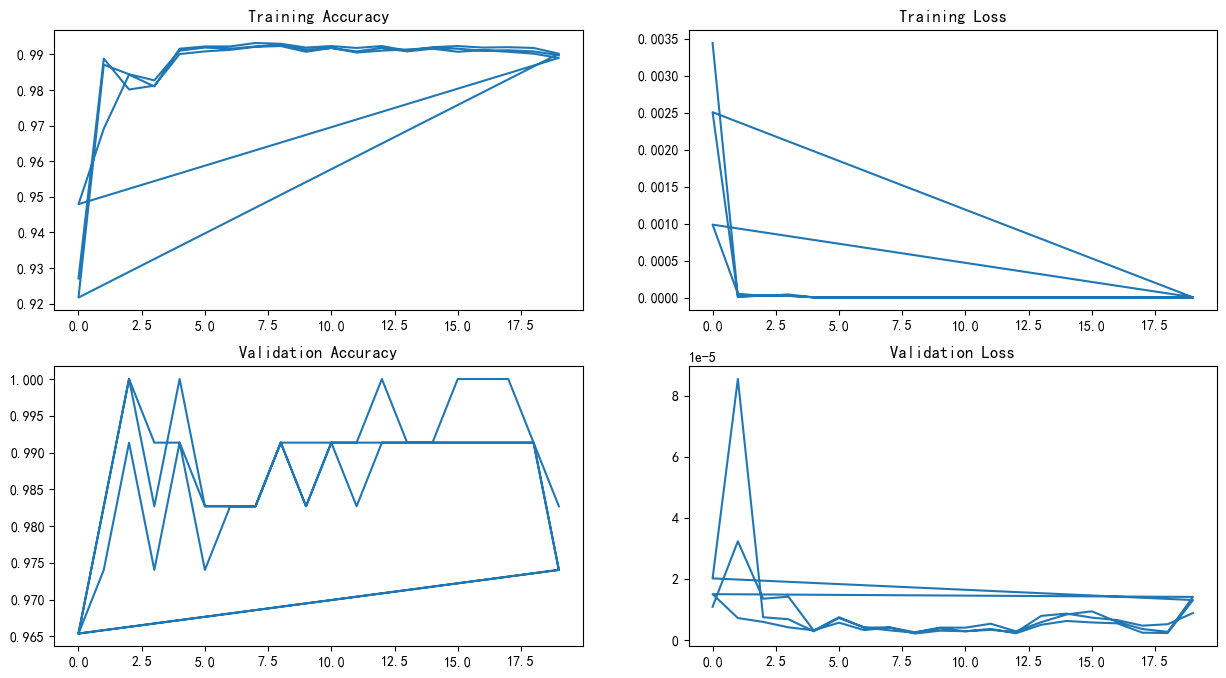

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 从"./log.csv"文件中读取日志数据
logs = pd.read_csv("./log.csv")

# 创建一个图形和四个子图（2行2列），并设置整个图形的大小
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

# 在第一个子图中绘制训练准确度（acc）随epoch的变化
ax[0][0].plot(logs['epoch'], logs['acc'], label='acc')
ax[0][0].set_title('Training Accuracy')  # 设置子图标题
# ax[0][0].legend() # 如果需要图例可以取消注释

# 在第二个子图中绘制训练损失（loss）随epoch的变化
ax[0][1].plot(logs['epoch'], logs['loss'], label='loss')
ax[0][1].set_title('Training Loss')  # 设置子图标题
# ax[0][1].legend() # 如果需要图例可以取消注释

# 在第三个子图中绘制验证准确度（val_acc）随epoch的变化
ax[1][0].plot(logs['epoch'], logs['val_acc'], label='val_acc')
ax[1][0].set_title('Validation Accuracy')  # 设置子图标题
# ax[1][0].legend() # 如果需要图例可以取消注释

# 在第四个子图中绘制验证损失（val_loss）随epoch的变化
ax[1][1].plot(logs['epoch'], logs['val_loss'], label='val_loss')
ax[1][1].set_title('Validation Loss')  # 设置子图标题
# ax[1][1].legend() # 如果需要图例可以取消注释

# 显示整个图形
plt.show()


## 单步预测

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]
    id  step          e_x          e_y
0    7     1   900.000000   900.000000
0    7     2   903.873955   909.219136
0    7     3   911.691370   915.455162
0    7     4   915.200903   924.819092
0    7     5   923.058370   931.004575
..  ..   ...          ...          ...
0    7   107  1488.812771  1735.102728
0    7   108  1493.495067  1743.938796
0    7   109  1501.406807  1750.054708
0    7   110  1506.485953  1758.668783
0    7   111  1511.542790  1767.295972

[111 rows x 4 columns]
[[[0.         0.        ]
  [0.00384436 0.00838037]
  [0.01160204 0.01404904]
  ...
  [0.03751464 0.05089712]
  [0.0452597  0

ValueError: math domain error

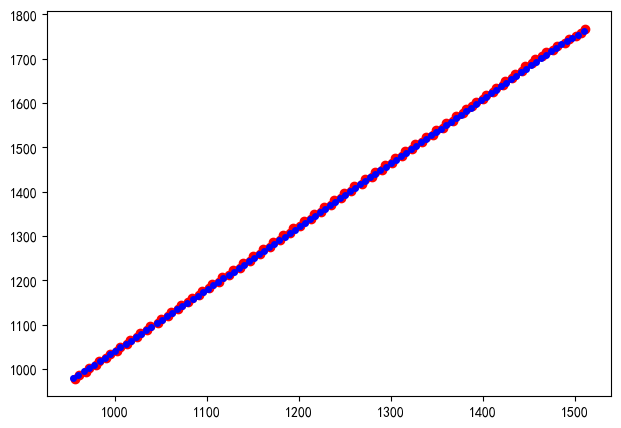

In [17]:

test_points_ids = list(set(test['id']))
print(test_points_ids)
for ids in test_points_ids[7:8]:
    y_pre = []
    print(test.loc[test.id == ids])
    #if(len(test.loc[test.id == ids]) < 30):
        #continue
    test_seq, test_label = createSequence(test.loc[test.id == ids], windows, maxmin)
    print(test_seq)
    y_true = test_label
    for i in range(len(test_seq)):
        y_hat = model.predict(test_seq[i].reshape(1, windows, 2))
        print(y_hat)
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')
    print(y_pre)
    f_y_pre, f_y_true = FNormalizeMult(y_pre, y_true, maxmin)

    print(f"最大值: {max(f_y_pre[:, 2])}\n最小值: {min(f_y_pre[:, 2])}\n均值: {np.mean(f_y_pre[:, 2])}\n"
          f"方差: {np.var(f_y_pre[:, 2])}\n标准差: {np.std(f_y_pre[:, 2])}\n中位数: {np.median(f_y_pre[:, 2])}")

    # 画测试样本数据库
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", markersize=6,label='真实值')
    plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo",markersize=4, label='预测值')
    bounds = [min(f_y_true[:, 0])-0.02,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.02,max(f_y_true[:, 1])+0.01]
    tbd.plot_map(plt,bounds,zoom = 16,style = 3)
    plt.legend(fontsize=14)
    plt.grid()
    plt.xlabel("经度",fontsize=14)
    plt.ylabel("纬度",fontsize=14)
    plt.title("id:",fontsize=17)

    meanss = np.mean(f_y_pre[:, 2])
    plt.subplot(122)
    plt.bar(range(f_y_pre.shape[0]),f_y_pre[:, 2],label='误差')
    plt.plot([0,f_y_pre.shape[0]],[meanss,meanss],'--r',label="均值")
    plt.title("预测值和真实值的误差",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("预测误差(KM)",fontsize=14)
    plt.text(f_y_pre.shape[0]*1.01,meanss*0.96,round(meanss,4),fontsize=14,color='r')
    plt.grid()
    plt.legend(fontsize=14)
'''
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(f_y_pre[:, 2], "b-", label='预测值')
    plt.plot(f_y_true[:, 2], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航速预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航速/节",fontsize=14)
    plt.grid()

    plt.subplot(122)
    plt.plot(f_y_pre[:, 3], "b-", label='预测值')
    plt.plot(f_y_true[:, 3], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航向预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航向/度",fontsize=14)
    plt.grid()'''

## 多步预测

1/1 [==============================] - 0s 13ms/step


MemoryError: 

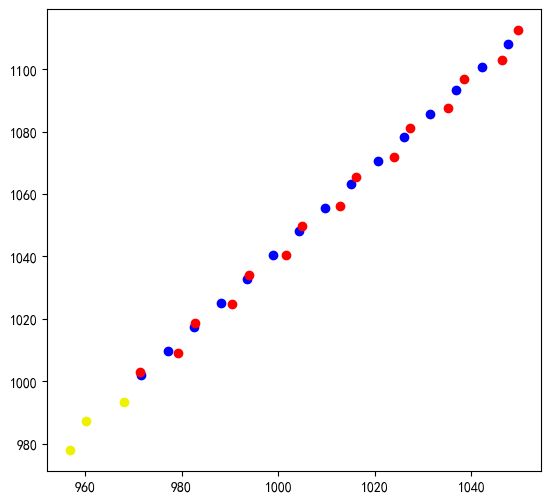

In [18]:
# 遍历测试数据集中的第一个船舶
for ids in test_points_ids[7:8]:
    # 创建测试数据的序列和标签
    test_seq, test_label = createSequence(test.loc[test.id == ids], windows, maxmin)

    # 初始化预测结果列表
    y_pre = []
    # 循环遍历每个时间步
    for i in range(len(test_seq)):
        # 使用模型进行单步预测
        y_hat = model.predict(test_seq[i].reshape(1, windows, 2))
        y_pre.append(y_hat[0])  # 将预测结果添加到预测列表中
    y_pre = np.array(y_pre, dtype='float64')

    # 反归一化处理，得到真实值
    _, true_labels = FNormalizeMult(y_pre, np.copy(test_label), maxmin)

    # 从第四个时间步开始进行多步预测
    for start_id in range(3, 4):
        # 初始化预测结果列表和真实值列表
        y_pre = []
        y_true = []
        # 获取当前时间步的序列
        pre_seq = test_seq[start_id]
        # 计算最大预测步数，限制在15步以内
        maxStep = min(15, test_seq.shape[0] - start_id)
        
        # 循环进行多步预测
        for i in range(maxStep):
            # 使用模型进行预测
            y_hat = model.predict(pre_seq.reshape(1, windows, 2))
            y_pre.append(y_hat[0])  # 将预测结果添加到预测列表中
            y_true.append(test_label[start_id + i])  # 将真实值添加到真实值列表中
            # 更新特征序列，以便下一步预测
            #中添加新的预测值，并在每次预测之后增加第一个数据点，以保持窗口大小不变。
            pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_pre[i], axis=0)[1:]

        # 转换预测值和真实值为数组
        y_pre = np.array(y_pre, dtype='float64')
        y_true = np.array(y_true, dtype='float64')

        # 反归一化处理
        f_y_pre, f_y_true = FNormalizeMult(y_pre, y_true, maxmin)

        # 绘制预测结果图形
        plt.figure(figsize=(14, 6))
        plt.subplot(121)
        plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo", label='预测值')
        plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", label='真实值')
        plt.plot(true_labels[:start_id, 0], true_labels[:start_id, 1], "o", color='#eef200', label='历史位置')
        bounds = [min(f_y_true[:, 0]) - 0.01, min(f_y_true[:, 1]) - 0.01, max(f_y_true[:, 0]) + 0.01,
                  max(f_y_true[:, 1]) + 0.01]
        tbd.plot_map(plt, bounds, zoom=16, style=3)
        plt.legend(fontsize=15)
        plt.title(f'预测步数量={maxStep},开始位置={start_id}', fontsize=17)
        plt.title(f'真实轨迹与预测轨迹', fontsize=17)
        plt.xlabel("经度", fontsize=15)
        plt.ylabel("纬度", fontsize=15)
        plt.grid()

        plt.subplot(122)
        plt.plot(np.arange(2, 2 * (maxStep) + 1, 2), f_y_pre[:, 2])
        plt.xticks(np.arange(2, 2 * (maxStep) + 1, 2))
        plt.title(f'随着时间迭代的距离误差', fontsize=17)
        plt.xlabel("时间/分钟", fontsize=15)
        plt.ylabel("距离误差/千米", fontsize=15)
        plt.grid()


In [ ]:
error_list = []
for ids in test_points_ids[:1]:
    test_seq, test_label = createSequence(test.loc[test.id == ids], windows, maxmin)
    # 要预测的时间
    pre_time = 30
    for start_id in range(test_seq.shape[0]-int(pre_time/2)):
        # 单值预测
        y_pre=[]
        y_true = []
        pre_seq = test_seq[start_id]
        # 循环预测
        for i in range(int(pre_time/2)):
            y_hat = model.predict(pre_seq.reshape(1, windows, 2))
            y_pre.append(y_hat[0])
            y_true.append(test_label[start_id+i])
            # 下一个数组，把预测的值作为预测序列的最后一个值，实现循环预测
            pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_pre[i], axis=0)[1:]

        y_pre = np.array(y_pre, dtype='float64')
        y_true = np.array(y_true, dtype='float64')
        f_y_pre,f_y_true = FNormalizeMult(y_pre,y_true,maxmin)
        error_list.append(list(f_y_pre[:,2]))

Text(0.5, 1.0, '整条轨迹上随时间变化的预测距离误差')

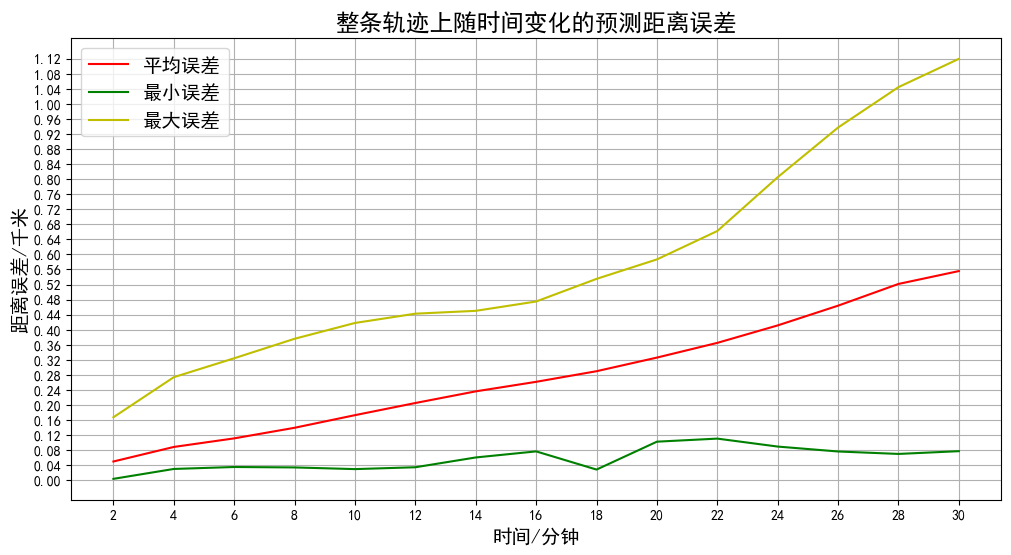

In [13]:
b = np.zeros([len(error_list),len(max(error_list,key = lambda x: len(x)))])
for i,j in enumerate(error_list):
    b[i][0:len(j)] = j

sums = b.sum(axis=0)
maxx = b.max(axis=0)
minx = []
means = []
for col in range(b.shape[1]):
    fzeros = b.shape[0] - list(b[:,col]).count(0.0)
    minx.append(min(list(b[:fzeros,col])))
    means.append(sums[col] / fzeros)

plt.figure(figsize=(12,6))
plt.plot(np.arange(2,2*(b.shape[1])+1,2),means,'-r',label='平均误差')
plt.plot(np.arange(2,2*(b.shape[1])+1,2),minx,'-g',label='最小误差')
plt.plot(np.arange(2,2*(b.shape[1])+1,2),maxx,'-y',label='最大误差')
plt.xticks(np.arange(2,2*(b.shape[1])+1,2))
plt.yticks(np.arange(0,max(maxx),0.04))
plt.xlabel("时间/分钟",fontsize=14)
plt.ylabel("距离误差/千米",fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.title("整条轨迹上随时间变化的预测距离误差",fontsize=17)